# 测试平滑化代码

原始代码来自`打开dat文件`程序


是否使用测试模式？输入 1 为测试（默认 te=1.000, tau=12.500），输入 0 为手动输入:  0.7
请输入 te 值（如 0.1）:  0.7
请输入 tau 值（如 10）:  14


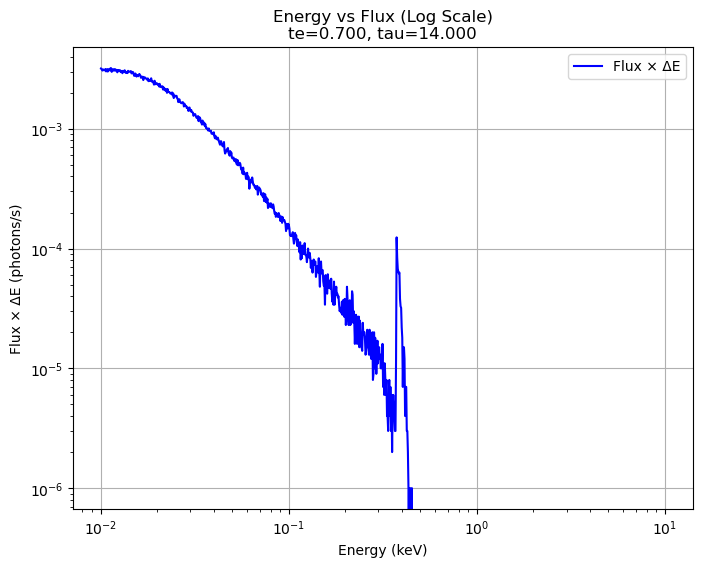

成功读取 te=0.700, tau=14.000 的数据！
能量数：1000，flux数：1000，de数：1000


In [108]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import os

# 读取 .dat 文件并解析其中的数据
def load_dat_file(file_path):
    """
    读取二进制 .dat 文件并解析其中的数据（假设数据是双精度浮动点数）。
    """
    if not os.path.exists(file_path):
        print(f"文件 {file_path} 不存在！")
        return None

    with open(file_path, "rb") as f:
        data = f.read()

    num_items = len(data) // 8
    result = struct.unpack("<" + "d" * num_items, data)
    return result

# 🔁 选择是否使用测试模式
test_mode = input("是否使用测试模式？输入 1 为测试（默认 te=1.000, tau=12.500），输入 0 为手动输入: ")

if test_mode.strip() == "1":
    te_str = "1.000"
    tau_str = "12.500"
    print("测试模式启用：te=1.000, tau=12.500")
else:
    # 让用户输入 te 和 tau
    te_input = input("请输入 te 值（如 0.1）: ")
    tau_input = input("请输入 tau 值（如 10）: ")
    te_str = f"{float(te_input):.3f}"
    tau_str = f"{float(tau_input):.3f}"

# ✅ 构造路径
base_file_path = r"\\wsl.localhost\Ubuntu-22.04\home\hdw\data\monk\plot\warmcorona\test\test_smooth_10_6\data_calspec_1000"
sub_dir = os.path.join(f"te_{te_str}_tau_{tau_str}", "calspec")

file_path_en = os.path.join(base_file_path, sub_dir, "en.dat")
file_path_flux = os.path.join(base_file_path, sub_dir, "flux.dat")
file_path_de = os.path.join(base_file_path, sub_dir, "de.dat")

# ✅ 读取数据
en = load_dat_file(file_path_en)
flux = load_dat_file(file_path_flux)
de = load_dat_file(file_path_de)

en = np.array(en)
flux = np.array(flux)
de = np.array(de)
# 检查数据是否加载成功
if en is None or flux is None or de is None:
    print("数据加载失败！")
else:
    # 计算 flux * de
    flux_de = np.multiply(flux, de)
    
    # 绘图
    plt.figure(figsize=(8, 6))
    plt.plot(en, flux_de, label="Flux × ΔE", color='b')
    plt.xlabel("Energy (keV)")
    plt.ylabel("Flux × ΔE (photons/s)")
    plt.title(f"Energy vs Flux (Log Scale)\nte={te_str}, tau={tau_str}")
    plt.xscale("log")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 打印信息
    print(f"成功读取 te={te_str}, tau={tau_str} 的数据！")
    print(f"能量数：{len(en)}，flux数：{len(flux)}，de数：{len(de)}")


## 第一个从末尾开始寻找非零数字寻找两端，是否有很多0，有的话就将其变为0

1000


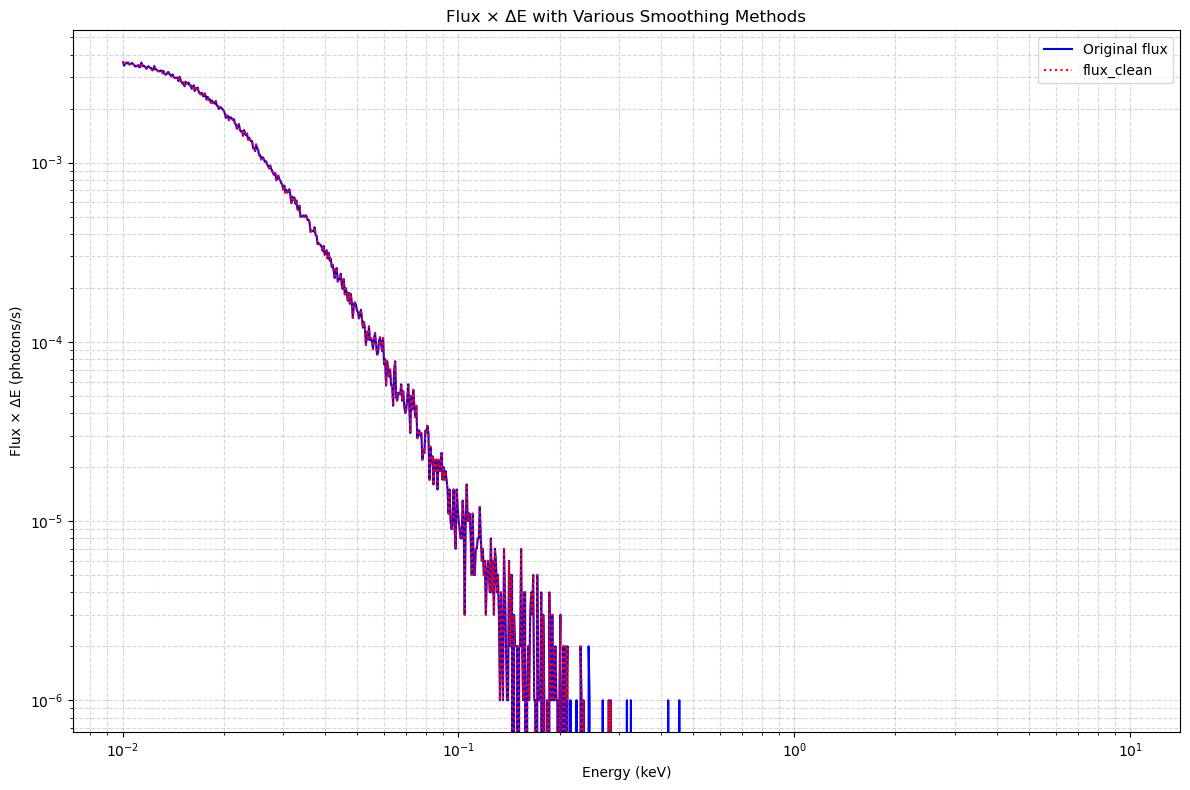

[5.24260474e+01 4.98014469e+01 5.07534188e+01 5.11246980e+01
 5.01552895e+01 5.04929247e+01 4.89827040e+01 4.86455094e+01
 4.87611167e+01 4.88185993e+01 4.77285711e+01 4.68116882e+01
 4.57325414e+01 4.55495957e+01 4.52753246e+01 4.55749594e+01
 4.40211901e+01 4.38207751e+01 4.60798124e+01 4.44720882e+01
 4.32989601e+01 4.31755911e+01 4.24198465e+01 4.11432476e+01
 4.15567055e+01 4.18896906e+01 4.12035136e+01 4.03212768e+01
 4.01031544e+01 3.86699399e+01 3.87789806e+01 4.03054517e+01
 3.83741329e+01 3.79951089e+01 3.72886889e+01 3.65901943e+01
 3.64733122e+01 3.65127246e+01 3.62058933e+01 3.49428589e+01
 3.55559187e+01 3.40069557e+01 3.34598421e+01 3.33259789e+01
 3.38949699e+01 3.38836531e+01 3.26844600e+01 3.21049414e+01
 3.13558129e+01 3.19729652e+01 3.08949554e+01 3.02157025e+01
 2.98465299e+01 2.97511089e+01 2.96655221e+01 2.80997320e+01
 2.95622512e+01 2.82104756e+01 2.72141543e+01 2.64509580e+01
 2.67263839e+01 2.52550375e+01 2.66135042e+01 2.57861122e+01
 2.56178736e+01 2.579142

In [91]:
# 第一种逻辑，看周围几个0中间全去掉
print(len(flux))
def clean_isolated_peaks_by_segment(flux, window=3):
    """
    清除被左右全为 0 包围的连续非零片段

    Parameters:
        flux (np.ndarray): 原始 flux 数组
        window (int): 左右窗口大小

    Returns:
        cleaned_flux (np.ndarray): 清洗后的 flux 数组（等长）
    """
    flux = np.array(flux, copy=True)
    n = len(flux)
    mask = flux != 0

    # 找出非零段
    segments = []
    i = 0
    while i < n:
        if mask[i]:
            start = i
            while i + 1 < n and mask[i + 1]:
                i += 1
            end = i
            segments.append((start, end))
        i += 1

    for start, end in segments:
        left_block = flux[max(0, start - window):start]
        right_block = flux[end+1:min(n, end+1 + window)]

        # 判断左右各 window 个点是否全为 0
        if len(left_block) == window and len(right_block) == window:
            if np.all(left_block == 0) and np.all(right_block == 0):
                flux[start:end+1] = 0

    return flux


flux_clean = clean_isolated_peaks_by_segment(flux, window=2) #这里修改window范围
plt.figure(figsize=(12,8))
plt.plot(en,flux*de,label='Original flux',color ='b')
plt.plot(en,flux_clean*de,label='flux_clean',color='r',linestyle=':')

plt.xlabel("Energy (keV)")
plt.ylabel("Flux × ΔE (photons/s)")
plt.title("Flux × ΔE with Various Smoothing Methods")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(flux)
print(len(flux))
#print(flux_clean-flux)

In [ ]:
# 第二种思路类似，
def clean_isolated_peaks(flux, window=3, zero_ratio_threshold=0.8):
    flux = np.array(flux, copy=True)
    n = len(flux)
    for i in range(n):
        if flux[i] == 0:
            continue
        start = max(0, i - window)
        end = min(n, i + window + 1)
        local = flux[start:end]
        zero_count = np.sum(local == 0) - (flux[i] == 0)
        local_count = len(local) - 1
        if local_count > 0 and zero_count / local_count >= zero_ratio_threshold:
            flux[i] = 0
    return flux


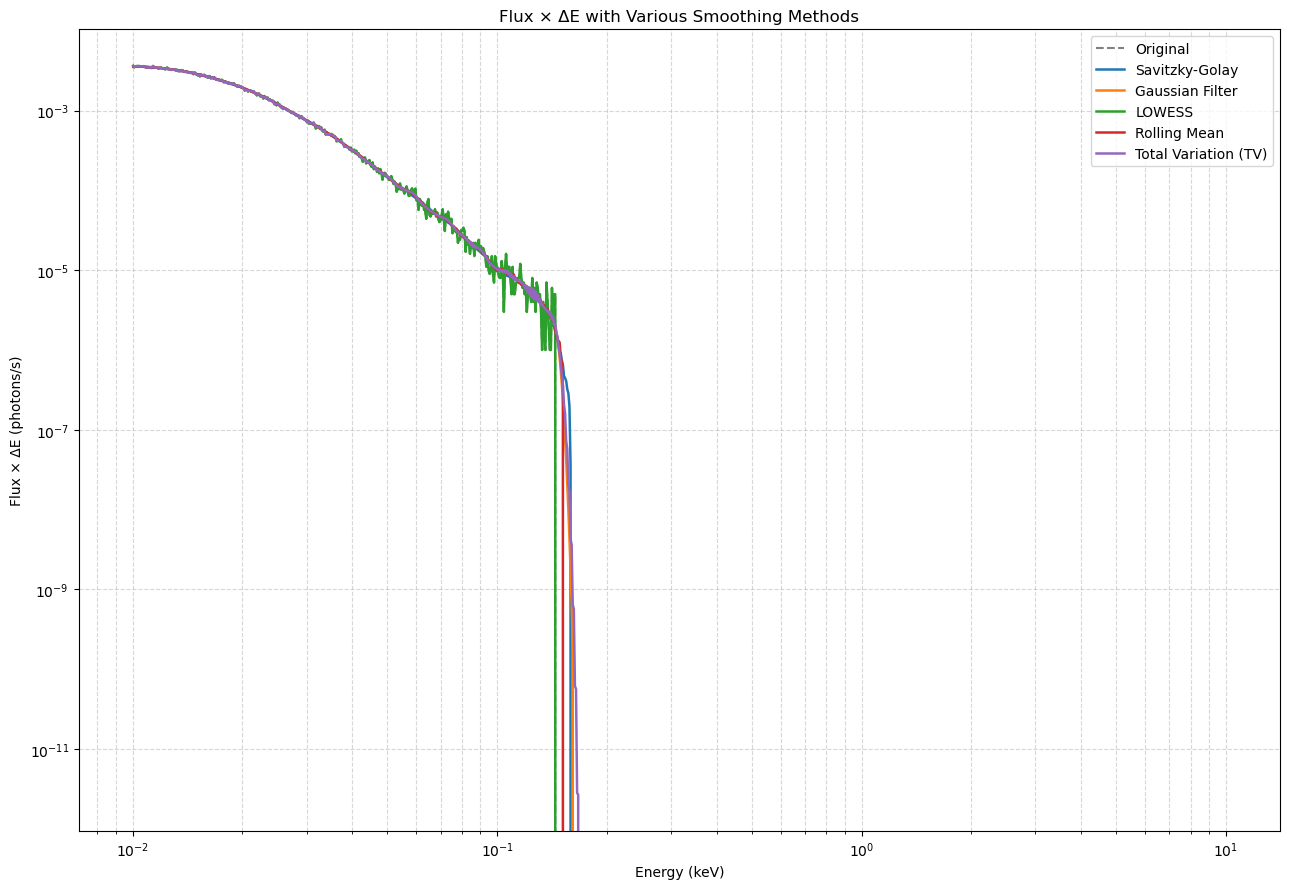

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.linalg import solve
from scipy.interpolate import UnivariateSpline, Akima1DInterpolator
from skimage.restoration import denoise_tv_chambolle 

# 假设你已经定义好 en, flux, de
# 示例数据（请替换为实际数据）
# en = np.array([...])
# flux = np.array([...])
# de = np.array([...])
#清理数据
flux = clean_isolated_peaks_by_segment(flux, window=1)

en = np.array(en)
flux = np.array(flux)
de = np.array(de)

# --- 方法 1: Savitzky-Golay ---
flux_smooth_savgol = savgol_filter(flux, 51, 3)
flux_de_smooth_savgol = flux_smooth_savgol * de

# --- 方法 2: Gaussian Filter ---
flux_smooth_gaussian = gaussian_filter1d(flux, sigma=4)
flux_de_smooth_gaussian = flux_smooth_gaussian * de

# --- 方法 3: LOWESS ---
flux_smooth_lowess = lowess(flux, en, frac=0.06, return_sorted=False)
flux_de_smooth_lowess = flux_smooth_lowess * de



# --- 方法 5: Rolling Mean ---
window = 15
flux_pad = np.pad(flux, (window//2, window//2), mode='edge')
flux_smooth_rolling = np.convolve(flux_pad, np.ones(window)/window, mode='valid')
flux_de_smooth_rolling = flux_smooth_rolling * de





# --- 方法 8: Total Variation Denoising ---
flux_smooth_tv = denoise_tv_chambolle(flux, weight=0.2)
flux_de_smooth_tv = flux_smooth_tv * de


# --- 统一绘图 ---
plt.figure(figsize=(13, 9))

plt.plot(en, flux * de, label="Original", lw=1.5, color='gray', linestyle='--')

plt.plot(en, flux_de_smooth_savgol, label="Savitzky-Golay", lw=1.8)
plt.plot(en, flux_de_smooth_gaussian, label="Gaussian Filter", lw=1.8)
plt.plot(en, flux_de_smooth_lowess, label="LOWESS", lw=1.8)
#plt.plot(en, flux_de_smooth_tikhonov, label="Tikhonov", lw=1.8)
plt.plot(en, flux_de_smooth_rolling, label="Rolling Mean", lw=1.8)
#plt.plot(en, flux_de_smooth_spline, label="Univariate Spline", lw=1.8)
#plt.plot(en, flux_de_smooth_akima, label="Akima Spline", lw=1.8)
plt.plot(en, flux_de_smooth_tv, label="Total Variation (TV)", lw=1.8)

plt.xlabel("Energy (keV)")
plt.ylabel("Flux × ΔE (photons/s)")
plt.title("Flux × ΔE with Various Smoothing Methods")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import find_peaks
import numpy as np

def evaluate_smoothing(original, smoothed, x):
    """
    评估平滑效果：误差、面积、结构等
    """
    # 数值误差
    mse = mean_squared_error(original, smoothed)
    mae = mean_absolute_error(original, smoothed)
    max_err = np.max(np.abs(original - smoothed))
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((original - smoothed) ** 2) / np.sum((original - np.mean(original)) ** 2)

    # 面积守恒
    integral_orig = np.trapz(original, x)
    integral_smooth = np.trapz(smoothed, x)
    flux_ratio = integral_smooth / integral_orig if integral_orig != 0 else np.nan

    # 一阶导数差异
    grad_orig = np.gradient(original, x)
    grad_smooth = np.gradient(smoothed, x)
    grad_mse = mean_squared_error(grad_orig, grad_smooth)

    # 峰值差异
    peaks_orig, _ = find_peaks(original)
    peaks_smooth, _ = find_peaks(smoothed)
    peak_diff = abs(len(peaks_orig) - len(peaks_smooth))

    return {
        "MSE": mse,
        "MAE": mae,
        "Max Error": max_err,
        "RMSE": rmse,
        "R²": r2,
        "∫Flux Ratio": flux_ratio,
        "∇MSE": grad_mse,
        "ΔPeaks": peak_diff,
        "Peaks_orig": len(peaks_orig),
        "Peaks_smooth": len(peaks_smooth)
    }

# 原始数据
flux_de = flux * de

# 平滑方法（保留有效的5种）
smooth_methods = {
    "Savitzky-Golay": flux_de_smooth_savgol,
    "Gaussian Filter": flux_de_smooth_gaussian,
    "LOWESS": flux_de_smooth_lowess,
    "Rolling Mean": flux_de_smooth_rolling,
    "Total Variation": flux_de_smooth_tv
}

# 批量评估
metrics_all = {
    name: evaluate_smoothing(flux_de, smoothed, en)
    for name, smoothed in smooth_methods.items()
}
print(f"{'Method':>20} | {'MSE':>10} | {'RMSE':>10} | {'MAE':>10} | {'R²':>6} | {'∫Ratio':>8} | {'∇MSE':>10} | {'ΔPeaks':>8}")
print("-" * 95)
for name, m in metrics_all.items():
    print(f"{name:>20} | {m['MSE']:.3e} | {m['RMSE']:.3e} | {m['MAE']:.3e} | {m['R²']:.4f} | {m['∫Flux Ratio']:.4f} | {m['∇MSE']:.3e} | {m['ΔPeaks']:>8}")
def sort_score(m):
    return (
        - m["MSE"]
        + 2.0 * m["R²"]
        - abs(1 - m["∫Flux Ratio"])
        - 0.5 * m["∇MSE"]
        - m["ΔPeaks"]
    )

ranked = sorted(metrics_all.items(), key=lambda x: -sort_score(x[1]))

print("\n📌 推荐方法优先级：")
for i, (name, m) in enumerate(ranked, 1):
    print(f"{i}. {name} (R²={m['R²']:.4f}, ∫Ratio={m['∫Flux Ratio']:.4f}, ΔPeaks={m['ΔPeaks']})")


              Method |        MSE |       RMSE |        MAE |     R² |   ∫Ratio |       ∇MSE |   ΔPeaks
-----------------------------------------------------------------------------------------------
      Savitzky-Golay | 3.882e-10 | 1.970e-05 | 7.580e-06 | 0.9995 | 1.0000 | 2.475e-02 |      118
     Gaussian Filter | 3.735e-10 | 1.933e-05 | 7.378e-06 | 0.9996 | 1.0022 | 2.592e-02 |      122
              LOWESS | 0.000e+00 | 0.000e+00 | 0.000e+00 | 1.0000 | 1.0000 | 0.000e+00 |        0
        Rolling Mean | 3.872e-10 | 1.968e-05 | 7.564e-06 | 0.9995 | 1.0027 | 2.520e-02 |      103
     Total Variation | 6.544e-11 | 8.089e-06 | 3.099e-06 | 0.9999 | 1.0006 | 2.728e-03 |       44

📌 推荐方法优先级：
1. LOWESS (R²=1.0000, ∫Ratio=1.0000, ΔPeaks=0)
2. Total Variation (R²=0.9999, ∫Ratio=1.0006, ΔPeaks=44)
3. Rolling Mean (R²=0.9995, ∫Ratio=1.0027, ΔPeaks=103)
4. Savitzky-Golay (R²=0.9995, ∫Ratio=1.0000, ΔPeaks=118)
5. Gaussian Filter (R²=0.9996, ∫Ratio=1.0022, ΔPeaks=122)


## 和107对比

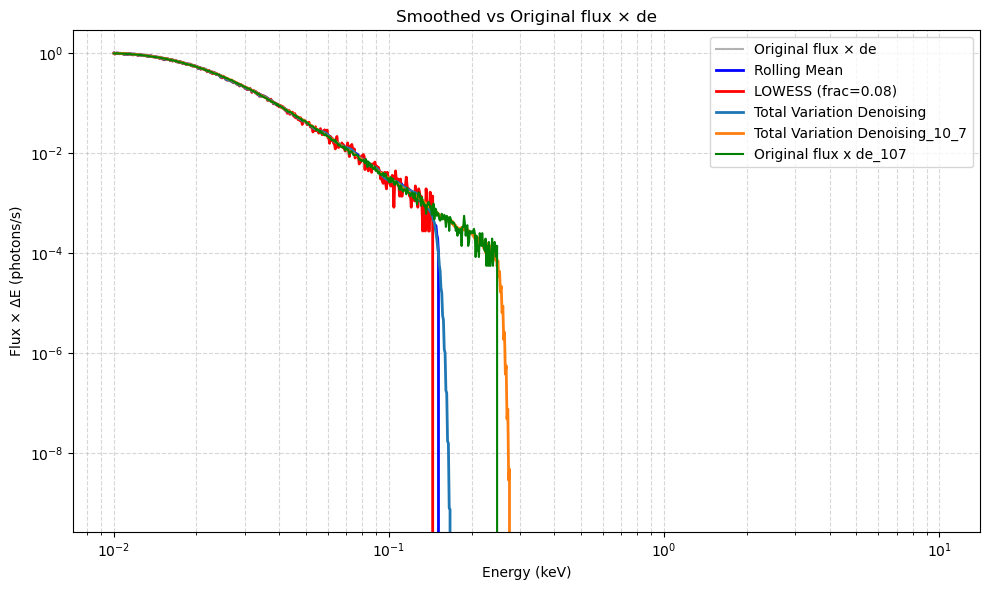

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from statsmodels.nonparametric.smoothers_lowess import lowess

base_file_path_10_7 = r"\\wsl.localhost\Ubuntu-22.04\home\hdw\data\monk\plot\warmcorona\test\test_smooth_10_7"
sub_dir = os.path.join(f"te_{te_str}_tau_{tau_str}", "calspec")

file_path_en_10_7 = os.path.join(base_file_path_10_7, sub_dir, "en.dat")
file_path_flux_10_7 = os.path.join(base_file_path_10_7, sub_dir, "flux.dat")
file_path_de_10_7 = os.path.join(base_file_path_10_7, sub_dir, "de.dat")

# ✅ 读取数据
en_10_7 = load_dat_file(file_path_en_10_7)
flux_10_7 = load_dat_file(file_path_flux_10_7)
de_10_7 = load_dat_file(file_path_de_10_7)

en_10_7 = np.array(en_10_7)
flux_10_7 = np.array(flux_10_7)
de_10_7 = np.array(de_10_7)

flux_10_7 = clean_isolated_peaks_by_segment(flux_10_7, window=1)

# 计算10_7时候的结果
flux_de_10_7 = en_10_7 * flux_10_7
# ✅ 强制转换为 NumPy 数组（避免 tuple 报错）
en = np.array(en)
flux = np.array(flux)
de = np.array(de)

# --- 方法 1: LOWESS ---
flux_smooth_lowess = lowess(flux, en, frac=0.06, return_sorted=False)
flux_de_smooth_lowess = flux_smooth_lowess * de



# --- 方法 2: Rolling Mean ---
window = 15
flux_pad = np.pad(flux, (window//2, window//2), mode='edge')
flux_smooth_rolling = np.convolve(flux_pad, np.ones(window)/window, mode='valid')
flux_de_smooth_rolling = flux_smooth_rolling * de





# --- 方法 3: Total Variation Denoising ---
flux_smooth_tv = denoise_tv_chambolle(flux, weight=0.2)
flux_de_smooth_tv = flux_smooth_tv * de

flux_smooth_tv_10_7 = denoise_tv_chambolle(flux_10_7, weight=0.2)
flux_de_smooth_tv_10_7 = flux_smooth_tv_10_7 * de

# --- 原始 flux × de ---
flux_de = flux * de

# 归一化
flux_de_norm = flux_de / np.max(flux_de)
flux_de_smooth_rolling_norm = flux_de_smooth_rolling / np.max(flux_de_smooth_rolling)
flux_de_smooth_lowess_norm = flux_de_smooth_lowess / np.max(flux_de_smooth_lowess)
flux_de_smooth_tv_norm = flux_de_smooth_tv / np.max(flux_de_smooth_tv)
flux_de_smooth_tv_10_7_norm = flux_de_smooth_tv_10_7 / np.max(flux_de_smooth_tv_10_7)
flux_de_10_7_norm = flux_de_10_7 / np.max(flux_de_10_7)


# --- 绘图 ---
plt.figure(figsize=(10, 6))

plt.plot(en, flux_de_norm, label='Original flux × de', color='gray', alpha=0.6)
plt.plot(en, flux_de_smooth_rolling_norm, label='Rolling Mean', color='blue', lw=2)
plt.plot(en, flux_de_smooth_lowess_norm, label='LOWESS (frac=0.08)', color='red', lw=2)
plt.plot(en, flux_de_smooth_tv_norm, label='Total Variation Denoising',lw=2)
plt.plot(en_10_7, flux_de_smooth_tv_10_7_norm, label='Total Variation Denoising_10_7',lw=2)
plt.plot(en_10_7,flux_de_10_7_norm,label="Original flux x de_107",color ='g')

plt.xlabel("Energy (keV)")
plt.ylabel("Flux × ΔE (photons/s)")
plt.title("Smoothed vs Original flux × de")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [360]:
print(flux_10_7)

[5.13642541e+01 5.11396101e+01 5.02440349e+01 5.09254558e+01
 5.00360058e+01 4.94044628e+01 4.90643649e+01 4.86097710e+01
 4.84526057e+01 4.77665795e+01 4.74242930e+01 4.71753780e+01
 4.72277458e+01 4.57830143e+01 4.56970386e+01 4.50638019e+01
 4.49034223e+01 4.43595551e+01 4.40350764e+01 4.39862480e+01
 4.32675476e+01 4.27251174e+01 4.21162279e+01 4.19973731e+01
 4.16642640e+01 4.14563489e+01 4.08129361e+01 4.02817696e+01
 3.99450246e+01 3.97255407e+01 3.90885557e+01 3.84293441e+01
 3.82769832e+01 3.78538333e+01 3.72442026e+01 3.70807068e+01
 3.64496866e+01 3.62546328e+01 3.54280713e+01 3.55610533e+01
 3.51553811e+01 3.46036262e+01 3.40135485e+01 3.34085167e+01
 3.31285007e+01 3.25526229e+01 3.22214389e+01 3.18953574e+01
 3.15825937e+01 3.10535753e+01 3.07928233e+01 3.04429035e+01
 2.99321510e+01 2.95720420e+01 2.95453102e+01 2.90725668e+01
 2.85843551e+01 2.81219226e+01 2.76200473e+01 2.71947713e+01
 2.71009727e+01 2.66247542e+01 2.63023396e+01 2.56105948e+01
 2.55307190e+01 2.494429

## 归一化

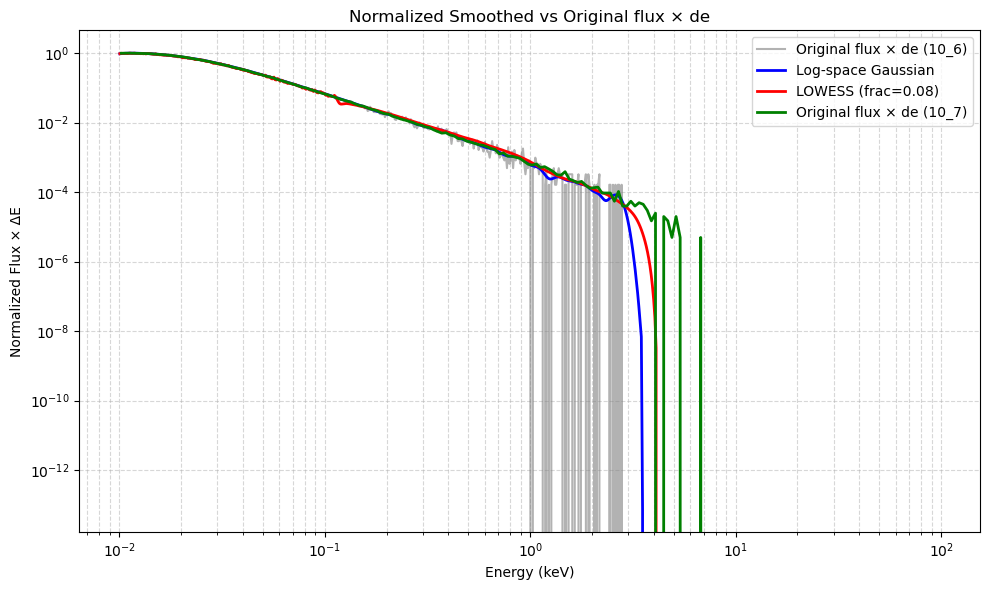

In [364]:
# --- 归一化 ---
flux_de_norm = flux_de / np.max(flux_de)
flux_de_smooth_log_gaussian_norm = flux_de_smooth_log_gaussian / np.max(flux_de_smooth_log_gaussian)
flux_de_smooth_lowess_norm = flux_de_smooth_lowess / np.max(flux_de_smooth_lowess)
flux_de_10_7_norm = flux_de_10_7 / np.max(flux_de_10_7)

# --- 绘图 ---
plt.figure(figsize=(10, 6))

plt.plot(en, flux_de_norm, label='Original flux × de (10_6)', color='gray', alpha=0.6)
plt.plot(en, flux_de_smooth_log_gaussian_norm, label='Log-space Gaussian', color='blue', lw=2)
plt.plot(en, flux_de_smooth_lowess_norm, label='LOWESS (frac=0.08)', color='red', lw=2)
plt.plot(en_10_7, flux_de_10_7_norm, label='Original flux × de (10_7)', color='green', lw=2)

plt.xlabel("Energy (keV)")
plt.ylabel("Normalized Flux × ΔE")
plt.title("Normalized Smoothed vs Original flux × de")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
